# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import utils
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import Image

# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Long-Short Term Memory Recurrent Neural Network

## Mathematical Description of a Recurrent Neural Network

The RNN differs from other NN architectures in that it can capture temporal or sequential dependencies in data. It does this by passing an activation/output/hidden state to each block that the block uses with the input from the sequence to produce both a prediction and an activation for the next block. In this way, information from earlier blocks can be passed down the sequence and influence predictions.

Given a data instance $\bf{x}$ of length $T$, each block performs the following operations on the $t^{th}$ element of $\bf{x}$:

$$a^{<t>}=g_1(W_{aa}a^{<t-1>}+W_{ax}{\bf{x}}^{<t>}+b_a)$$

$$y^{<t>}=g_2(W_{ya}a^{<t>}+b_y)$$

In the above, $W_{aa}$ are the weights associate with the activation of the previous block, $W_{ax}$ are the weights associated with the input from the sequence, $W_{ya}$ are the weights used to calculate the prediction, and $b_a$ and $b_y$ are the biases used to calculate the activation and the prediction, respectively. The $g$ functions are the activation functions of the block.

A graphical representation of the RNN block looks like:

<img src="Graphics/RNN Cell.png" width="600" height="600" />

Thus, each block recieves a sequential input and an activation, calculates the next activation and prediction, and feeds the activation to the next block in the following fashion:

<img src="Graphics/RNN.png" width="600" height="600" />

They can also be stacked to give a Deep RNN:

<img src="Graphics/Deep RNN.png" width="600" height="600" />

However, for our purposes, we are not interested in a prediction for each member of our sequence, but a single prediction after the RNN has had the opportunity to see the entire sequence. This is often call "Many-to-One", as the RNN receives an input of "many" and outputs a single final prediction, "one". 

Graphically, it is represented as:

<img src="Graphics/Many to One RNN.png" width="600" height="600" />

## Mathematical Description of a Long-Short Term Memory Recurrent Neural Network

Unfortunately, the simple RNN depicted above struggles with longer sequences due to the problem of Vanishing Gradients. 

To remedy this, we introduce the Long-Short Term Memory Recurrent Neural Network, which modifies the blocks with gates that allow for more complex consideration of the information the block recieves and exports to the next.

We calculate each gate with:

$$\Gamma=\sigma(W{\bf{x}}^{<t>}+Ua^{<t-1>}+b)$$

In the above, $W,U$ and $b$ are the weights associated with the input, the weights associated with the activation, and the bias of the gate. $\sigma$ is the sigmoid activation function. Thus, each gate has a value between 0 and 1.

The LSTM block has four gates, the Update Gate $\Gamma_u$, Relevance Gate $\Gamma_r$, Forget Gate $\Gamma_f$, and the Output Gate $\Gamma_o$.

Once we have each gate, we calculate the activation $a^{<t>}$ and a new quantity, $c^{<t>}$, which will tell the subsequent block how to handle the activation.

They are calculated in the following manner:

$$\tilde{c}^{<t>}=tanh(W_c[\Gamma_r * a^{<t-1>}, {\bf{x}}^{<t>}]+b_c)$$

$$c^{<t>}=\Gamma_u * \tilde{c}^{<t>} + \Gamma_f c^{<t-1>}$$

$$a^{<t>}=\Gamma_o * c^{<t>}$$

We note that the * symbol is element-wise multiplication.

Graphically, this looks like:

<img src="Graphics/LSTM Cell.png" width="600" height="600" />

# Training

## X, y, X_test, and y_test sets

In [3]:
# Defining a function to create two PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [4]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


## Train, Test, and Validation Lagged Sets

In [5]:
# Lagging function

def lagged_matrices(n_steps, X_matrix, y_matrix):
    X_lagged=[]
    y_lagged=[]
    y_matrix=y_matrix
    for i in range(n_steps, X_matrix.shape[0]):
        lag_set=X_matrix[i-n_steps:i]
        X_lagged.append(lag_set) # We are taking the last n_input to the present time periods as the 
        # X values.
        y_lagged.append(int(y_matrix[i-1]))
    X_lagged=np.array(X_lagged) # They need to be arrays
    return X_lagged, y_lagged
    # Note, this does not include the last slice

In [6]:
## Getting our training, validation, and testing sets

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
print('Second to last X and y test after PCA:', '\n',X_test[-2], y_test[-2])
print('Final X and y test after PCA:', '\n',X_test[-1], y_test[-1])

# Classes, sets, and features
num_classes=2 
n_steps = 12 # How many time periods into the past we will look.
n_features = 20 # Number of PCA features

# Getting our lagged matrices
X_set, y_set=lagged_matrices(n_steps, X, y)
X_test, y_test=lagged_matrices(n_steps, X_test, y_test)

# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

# Making sure the y sets are arrays
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

print('X_train shape:',X_train.shape) # Confirming that our shape is (n_instances, n_steps, n_features)
print('Final X and y test after PCA:', '\n',X_test[-1][-1], y_test[-1])

Second to last X and y test after PCA: 
 [12.00381295 10.53103332 -1.88724162 -1.1895646  -2.92464478  3.88806865
 -0.08486031 -1.60395372 -2.61335648 -0.14934652 -0.73597245  1.54475006
  2.13617841 -1.16336857 -0.96483303 -0.52009331 -0.53966372  0.15052999
 -0.07018077  0.0888259 ] 0.0
Final X and y test after PCA: 
 [ 1.19564840e+01  1.00366560e+01 -6.45265865e-01 -1.32061430e+00
 -3.30942941e+00  3.79137389e+00  4.11759151e-01 -7.04865916e-01
 -1.77866589e+00 -4.68654783e-01 -8.73414514e-01  1.15515294e+00
  1.72232774e+00 -9.64270887e-01 -1.74905002e+00 -3.91583898e-01
 -4.62367209e-01 -5.03010421e-03 -4.92723940e-02 -2.06058823e-01] 0.0
X_train shape: (21011, 12, 20)
Final X and y test after PCA: 
 [12.00381295 10.53103332 -1.88724162 -1.1895646  -2.92464478  3.88806865
 -0.08486031 -1.60395372 -2.61335648 -0.14934652 -0.73597245  1.54475006
  2.13617841 -1.16336857 -0.96483303 -0.52009331 -0.53966372  0.15052999
 -0.07018077  0.0888259 ] 0


This confirms that our sequence creation function does not include the final datum.

## Grid Search

In [10]:
def create_lstm_model(activ_function='relu', units=50, dropout_rate=0.1, num_layers=2, 
                     optimizer='adam',learning_rate=1e-3,
                     n_steps=n_steps, n_features=n_features):
    # create model
    model = keras.Sequential()
        
    if num_layers==2:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), 
               return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))

        
    if num_layers==3:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==4:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fourth layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))
        
    # Final layer with sigmoid for classification
    model.add(keras.layers.Dense(1, activation="sigmoid"))
        
    # Running through the optimizers
    if optimizer=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    if optimizer=='RMSprop':
        optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
        
    if optimizer=='SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
        )    
    return model

Note, the grid search section for this script, as well as the CNN and MLP, take heavy influence from the following Kaggle notebook: MNIST: CNN, grid search, data augmentation

This can be found at:

https://www.kaggle.com/code/cedricb/mnist-cnn-grid-search-data-augmentation/notebook

In [11]:
# Creating and compiling the model with a summary

lstm = create_lstm_model()
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 50)            14200     
                                                                 
 dropout (Dropout)           (None, 12, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,451
Trainable params: 34,451
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Optimize the model with grid search

# Grid search parameters
n_epochs_cv = 20 # Number of epochs for our grid search
n_cv = 3 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(build_fn=create_lstm_model, verbose=1)

# Define parameters and values for grid search to check in our model
param_grid = {
    # Model parameters
    'activ_function':['relu', 'tanh', 'sigmoid'],
    'units':[256, 512, 1024],
    'dropout_rate':[0.1],
    'num_layers':[2, 3, 4],
    'optimizer':['adam', 'RMSProp', 'SGD'],
    'learning_rate':[1e-3, 1e-5, 1e-7],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_params_)

In [ ]:
# Creating and compiling a model with the best parameters from the grid search

lstm_model=create_lstm_model(activ_function=grid_result.best_params_['activ_function'], 
                                            units=grid_result.best_params_['neurons'], 
                                            dropout_rate=grid_result.best_params_['dropout_rate'],
                                            num_layers=grid_result.best_params_['num_layers'],
                                            optimizer=grid_result.best_params_['optimizer'],
                          learning_rate=grid_result.best_params_['learning_rate'])

# Fitting the model
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val), verbose=0)

In [12]:
# Creating and compiling a model with the best parameters from the cluster

lstm_model=create_lstm_model(activ_function='sigmoid', 
                                            units=256, 
                                            dropout_rate=0.5,
                                            num_layers=4,
                                            optimizer='RMSProp',
                          learning_rate=1e-5)

# Fitting the model
history = lstm_model.fit(np.array(X_train), np.array(y_train), epochs=20,
                         validation_data=(np.array(X_val),np.array(y_val)), verbose=1)

Epoch 1/20
657/657 [==============================] - 110s 160ms/step - loss: 0.7053 - accuracy: 0.4985 - val_loss: 0.7100 - val_accuracy: 0.4860
Epoch 2/20
657/657 [==============================] - 96s 146ms/step - loss: 0.6921 - accuracy: 0.5329 - val_loss: 0.6899 - val_accuracy: 0.5481
Epoch 3/20
657/657 [==============================] - 101s 153ms/step - loss: 0.6887 - accuracy: 0.5444 - val_loss: 0.6843 - val_accuracy: 0.5532
Epoch 4/20
657/657 [==============================] - 93s 141ms/step - loss: 0.6872 - accuracy: 0.5483 - val_loss: 0.6840 - val_accuracy: 0.5545
Epoch 5/20
657/657 [==============================] - 100s 152ms/step - loss: 0.6858 - accuracy: 0.5482 - val_loss: 0.6895 - val_accuracy: 0.5344
Epoch 6/20
657/657 [==============================] - 103s 156ms/step - loss: 0.6861 - accuracy: 0.5519 - val_loss: 0.6886 - val_accuracy: 0.5450
Epoch 7/20
657/657 [==============================] - 109s 166ms/step - loss: 0.6860 - accuracy: 0.5527 - val_loss: 0.6854 - v

## Performance

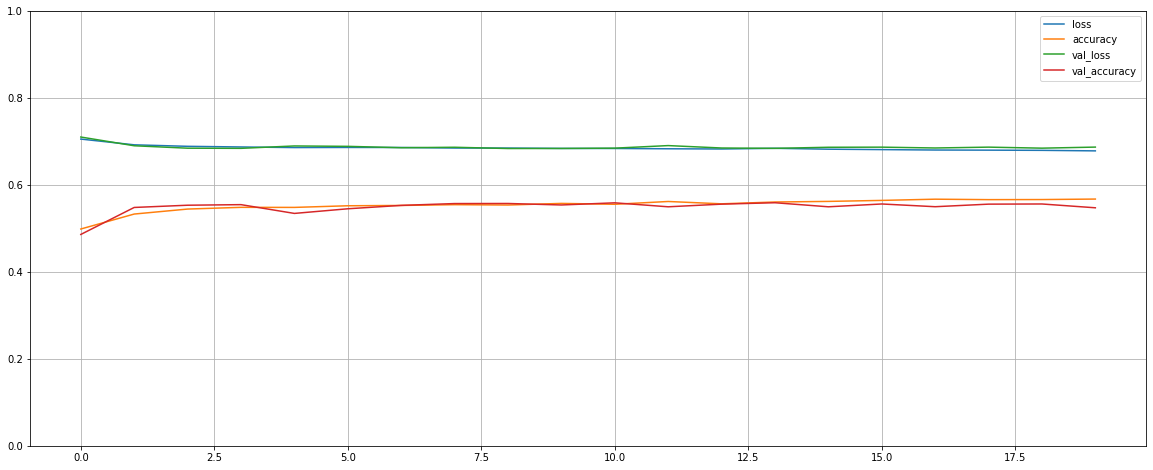

In [13]:
# Training Performance

history.history.keys()
pd.DataFrame(history.history).plot(figsize=(20, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

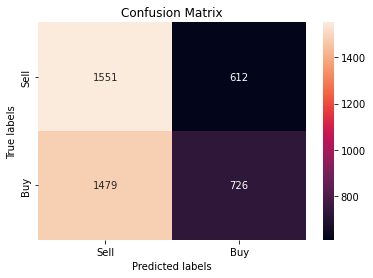

In [14]:
# Confusion Matrix

# # Performance
y_pred=lstm_model.predict(X_test) # Returns a list where every element is an array with the continuous
# value prediction
y_pred=[x[0] for x in y_pred] # Getting all the continuous value predictions from the arrays
for i in range(len(y_pred)): # Transforming the continuous value into binary labels
    if y_pred[i] <= 0.5:
        y_pred[i] = 0
    if y_pred[i] > 0.5:
        y_pred[i] = 1

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

## Saving and Reloading the Model

In [24]:
# # Saving the model

# lstm_model.save('Models/LSTM Class 12 BTC.h5')

In [ ]:
# # Reloading the model

# lstm_class_model=model = keras.models.load_model('Models/LSTM Class 12 BTC.h5')